In [1]:
!pip install -qqq wandb --upgrade
!pip install -qq librosa --upgrade
# !pip install -qqq git+https://github.com/drscotthawley/aeiou.git

In [2]:
import numpy as np

import holoviews as hv 
import panel as pn
from bokeh.resources import INLINE
hv.extension("bokeh", logo=False)

import torch
import librosa
import torchaudio
import torchaudio.transforms as T

from scipy.io import wavfile
from scipy.signal import spectrogram

import wandb

In [29]:
def generate_melspec(audio_data, sample_rate=48000, power=2.0, n_fft = 1024, win_length = None, hop_length = None, n_mels = 128):
  if hop_length is None:
     hop_length = n_fft//2

  # convert to torch
  audio_data = torch.tensor(audio_data, dtype=torch.float32)

  mel_spectrogram = T.MelSpectrogram(
      sample_rate=sample_rate,
      n_fft=n_fft,
      win_length=win_length,
      hop_length=hop_length,
      center=True,
      pad_mode="reflect",
      power=power,
      norm="slaney",
      onesided=True,
      n_mels=n_mels,
      mel_scale="htk",
  )

  melspec = mel_spectrogram(audio_data).numpy()
  mel_db = np.flipud(librosa.power_to_db(melspec))
  return mel_db


def wandb_spectrogram(audio_path:str, sample_rate=None, specs:str=['all_specs'], layout:str='row', height=170, width=400):
  '''
    Takes a .wav file and returns a wandb.HTML object with spectrograms of the audio

    audio_path: path to .wav file
    sr: sample rate. If set to None then the audio files
    specs : 
      "all_specs", spetrograms only
      "all", all plots
      "melspec", melspectrogram only
      "spec", spectrogram only
      "waveform", waveform only, equivalent to wandb.Audio object
    layout: how the spectrograms are laid out in wandb, either stacked or side-by-side
      "row", widgets set side by side
      "grid", widgets arranged across 2 rows
    height: height of each spectrogram in wandb
    width: height of each spectrogram in wandb
  '''

  # Read data
  sr, audio_data = wavfile.read(audio_path)
  if sample_rate is None:
    sample_rate = sr

  duration = librosa.get_duration(filename=audio_path)
                                
  # audio_data *= (2 ** (nbits - 1))
  if len(audio_data.shape) > 1: 
    audio_data = audio_data[:,0] # get one channel

  # Audio widget
  audio = pn.pane.Audio(audio_data, sample_rate=sample_rate, name='Audio', throttle=10)

  # Add HTML components
  line = hv.VLine(0).opts(color='red')
  line2 = hv.VLine(0).opts(color='green')
  line3 = hv.VLine(0).opts(color='white')

  slider = pn.widgets.FloatSlider(end=duration, visible=False, step=0.001)
  slider.jslink(audio, value='time', bidirectional=True)
  slider.jslink(line, value='glyph.location')
  slider.jslink(line2, value='glyph.location')
  slider.jslink(line3, value='glyph.location')

  # Spectogram plot
  if ('spec' in specs) or ('all_specs' in specs) or ('all' in specs):
    f, t, sxx = spectrogram(audio_data, sample_rate)
    spec_gram_hv = hv.Image((t, f, np.log10(sxx)), ["Time (s)", "Frequency (hz)"]).opts(
        width=width, height=height, labelled=[], axiswise=True, color_levels=512) * line
  else: 
    spec_gram_hv = None

  # Melspectogram plot
  if ('melspec' in specs) or ('all_specs' in specs) or ('all' in specs):
    mel_db = generate_melspec(audio_data, sample_rate=sample_rate, power=2.0, n_fft = 1024, n_mels = 128)
    melspec_gram_hv = hv.Image(mel_db, bounds=(0, 0, duration, mel_db.max()), kdims=["Time (s)", "Mel Freq"]).opts(
        width=width, height=height, labelled=[], axiswise=True, color_levels=512) * line3
  else:
    melspec_gram_hv = None

  # Waveform plot
  if ('waveform' in specs) or ('all' in specs):
    time = np.linspace(0, len(audio_data)/sample_rate, num=len(audio_data))
    line_plot_hv = hv.Curve((time, audio_data), ["Time (s)", "amplitude"]).opts(
        width=width, height=height, axiswise=True) * line2
  else:
    line_plot_hv = None


  # Create HTML layout
  html_file_name = "audio_spec.html"

  if layout == 'grid': 
    print('doing GRID')
    combined = pn.GridBox(audio, spec_gram_hv, line_plot_hv, melspec_gram_hv, slider, ncols=2, nrows=2).save(html_file_name)
  else: 
    combined = pn.Row(audio, line_plot_hv, spec_gram_hv, melspec_gram_hv, slider).save(html_file_name)

  # if layout == 'grid': 
  #   combined = pn.GridBox(audio, spec_gram * line, None, melspec_gram * line3, slider, ncols=2, nrows=2).save(html_file_name)
  # else: 
  #   combined = pn.Row(audio, spec_gram * line, melspec_gram * line3, slider).save(html_file_name)

  return wandb.Html(html_file_name)

In [30]:
wandb.init(project='audio_test')

# download audio file
wandb.use_artifact('morg/audio_test/nell_20s:v0', type='audio_file').download('.')

my_table = wandb.Table(columns=['audio_spec', 'audio'])

for f in range(10):
  audio_path = 'nell_20s.wav'

  wandb_spec = wandb_spectrogram(audio_path, specs=['all'], layout='grid')
  wandb_audio = wandb.Audio(audio_path, caption=audio_path)

  my_table.add_data(wandb_spec, wandb_audio)

# LOG
wandb.log({"audio_table4": my_table})
wandb.finish()

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:540: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


doing GRID


# IGNORE THE JUNK BELOW HERE

In [ ]:
import wandb
run = wandb.init(project='audio_test', job_type='download_data')
run.use_artifact('morg/audio_test/nell_20s:v0', type='audio_file').download('.')
wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


  0%|          | 0.00/106k [00:00<?, ?B/s]

duration is 19.99238095238095
44100 torch.float32 torch.Size([2, 881664])
torch.Size([2, 128, 1723])
avg seg length: 0.01160323909018047


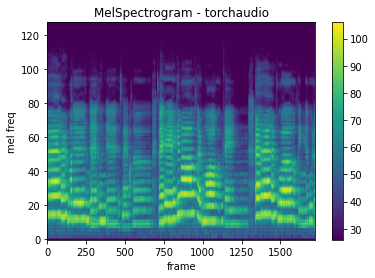

In [ ]:
# import torchaudio

# from scipy.io import wavfile
# from librosa import load

# import torch
# import torchaudio
# import torchaudio.functional as F
# import torchaudio.transforms as T
# from torchaudio.utils import download_asset

# import matplotlib.pyplot as plt

# import librosa
# def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
#     fig, axs = plt.subplots(1, 1)
#     axs.set_title(title or "Spectrogram (db)")
#     axs.set_ylabel(ylabel)
#     axs.set_xlabel("frame")
#     im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
#     fig.colorbar(im, ax=axs)
#     plt.show(block=False)

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
# audio_path = SAMPLE_SPEECH

# audio_path = 'nell_20s.wav'
# # audio_data = load_audio(audio_path, sr=None)
# # audio_data, sr = torchaudio.load(audio_path)

# sr, audio_data = wavfile.read(audio_path)
# duration = librosa.get_duration(filename=audio_path)
# print(f"duration is {duration}")
# # convert to torch
# audio_data = torch.tensor(audio_data.transpose(1,0), dtype=torch.float32)

# print(sr, audio_data.dtype, audio_data.shape)


# n_fft = 1024
# win_length = None
# hop_length = 512
# n_mels = 128

# mel_spectrogram = T.MelSpectrogram(
#     sample_rate=sr,
#     n_fft=n_fft,
#     win_length=win_length,
#     hop_length=hop_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
#     norm="slaney",
#     onesided=True,
#     n_mels=n_mels,
#     mel_scale="htk",
# )

# melspec = mel_spectrogram(audio_data)
# t_length = melspec.shape[-1]
# print(melspec.shape)

# avg_seg_length = duration/t_length
# print(f'avg seg length: {avg_seg_length}')
# plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

torch.Size([881664])
torch.Size([128, 1723])
internal melspec: torch.Size([128, 1723])
internal melspec: torch.Size([128, 1723])


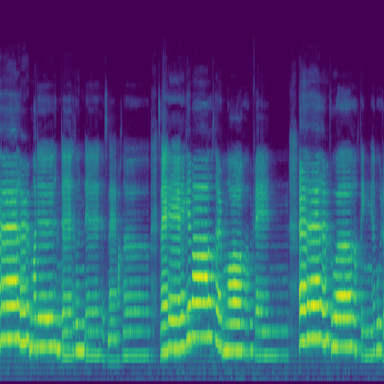

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image

def spectrogram_image(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None, db_range=[None,None], justimage=False):
    "Modified from PyTorch tutorial https://pytorch.org/tutorials/beginner/audio_feature_extractions_tutorial.html"
    fig = Figure(figsize=(5, 4), dpi=100) if not justimage else Figure(figsize=(4.145, 4.145), dpi=100, tight_layout=True)
    canvas = FigureCanvasAgg(fig)
    axs = fig.add_subplot()
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect, vmin=db_range[0], vmax=db_range[1])
    if xmax:
        axs.set_xlim((0, xmax))
    if justimage:
        axs.axis('off')
        plt.tight_layout()
    else: 
        axs.set_ylabel(ylabel)
        axs.set_xlabel('frame')
        axs.set_title(title or 'Spectrogram (dB)')
        fig.colorbar(im, ax=axs)
    canvas.draw()
    rgba = np.asarray(canvas.buffer_rgba())
    im = Image.fromarray(rgba)
    if justimage: # remove tiny white border
        b = 15 # border size 
        im = im.crop((b,b, im.size[0]-b, im.size[1]-b))
        #print(f"im.size = {im.size}")
    return im

def audio_spectrogram_image(waveform, power=2.0, sample_rate=48000, print=print, db_range=[None, None], justimage=False, log=False):
    "Modified from PyTorch tutorial https://pytorch.org/tutorials/beginner/audio_feature_extractions_tutorial.html"
    n_fft = 1024
    win_length = None
    hop_length = n_fft//2 # 512
    n_mels = 128

    mel_spectrogram_op = T.MelSpectrogram(
        sample_rate=sample_rate, n_fft=n_fft, win_length=win_length, 
        hop_length=hop_length, center=True, pad_mode="reflect", power=power, 
        norm='slaney', onesided=True, n_mels=n_mels, mel_scale="htk")

    melspec = mel_spectrogram_op(waveform.float())

    print(f"internal melspec: {melspec.shape}")

    if log:
        print_stats(melspec, print=print) 
        print(f"torch.max(melspec) = {torch.max(melspec)}")
        print(f"melspec.shape = {melspec.shape}")
    # melspec = melspec[0] # TODO: only left channel for now
    return spectrogram_image(melspec, title="MelSpectrogram", ylabel='mel bins (log freq)', db_range=db_range, justimage=justimage)


n_fft = 1024
win_length = None
hop_length = n_fft//2 # 512
n_mels = 128
power = 2.0

mel_spectrogram_op = T.MelSpectrogram(
    sample_rate=sr, n_fft=n_fft, win_length=win_length, 
    hop_length=hop_length, center=True, pad_mode="reflect", power=power, 
    norm='slaney', onesided=True, n_mels=n_mels, mel_scale="htk")

# Load data
sr, audio_data = wavfile.read(audio_path)
duration = librosa.get_duration(filename=audio_path)

if len(audio_data.shape) > 1: 
  audio_data = audio_data[:,0] # get one channel

# convert to torch
audio_data = torch.tensor(audio_data, dtype=torch.float32)

print(audio_data.shape)

# Get melspec
melspec = mel_spectrogram_op(audio_data)
print(melspec.shape)

avg_t = duration / melspec.shape[-1]
t = np.linspace(0, duration, melspec.shape[-1])
f = list(range(melspec.shape[1]))
sxx = melspec[0]

im = audio_spectrogram_image(audio_data, power=2.0, sample_rate=sr, 
                        #  db_range=[20,120],
                         justimage=True, log=False)
# print(len(t), t)
# print(melspec[0].shape)
# sxx = melspec[0]

# melspec_gram = hv.Image((t, f, np.log10(sxx)), ["Time (s)", "Frequency (hz)"]).opts(width=500, height=150, labelled=[])
# melspec_gram

scott_im = audio_spectrogram_image(audio_data, power=2.0, sample_rate=sr, 
                        #  db_range=[20,120],
                         justimage=True, log=False)

wandb.init(project='audio_test')
wandb.log(wandb.Image(scott_im))

In [ ]:
# TEST
# im = testing_melspec()
# wandb.log({'aeiou_reference':wandb.Image(im)})

In [ ]:
# sr, audio_data = wavfile.read(audio_path)
# duration = librosa.get_duration(filename=audio_path)
                                
# # # librosa
# # audio_data, sr = load(audio_path, sr=None, mono=None)
# # audio_data = np.transpose(audio_data)
# # audio_data *= (2 ** (nbits - 1))

# if len(audio_data.shape) > 1: 
#   audio_data = audio_data[:,0] # get one channel

# # # Mel Spectrogram
# n_fft = 1024
# win_length = None
# hop_length = 512
# n_mels = 128

# mel_spectrogram = T.MelSpectrogram(
#     sample_rate=sr,
#     n_fft=n_fft,
#     win_length=win_length,
#     hop_length=hop_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
#     norm="slaney",
#     onesided=True,
#     n_mels=n_mels,
#     mel_scale="htk",
# )


# # convert to torch
# audio_data = torch.tensor(audio_data, dtype=torch.float32)
# melspec = mel_spectrogram_op(audio_data).numpy()
# print(f"melspec max: {melspec.max()}")
# print(f"melspec max: {melspec.min()}")

# # avg_t = duration / melspec.shape[-1]
# m_t = np.linspace(0, duration, melspec.shape[-1])
# m_f = np.array(list(range(melspec.shape[0])))

# # melspec = mel_spectrogram(audio_data.transpose())
# # print(f.shape, t.shape, sxx.shape)
# # print(melspec.shape)
# # plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

# # melspec_gram = hv.Image((t, f, np.log10(sxx)), ["Time (s)", "Frequency (hz)"]).opts(width=500, height=150, labelled=[])
# print(f"melspec_gram, m_t, m_f, melspec: {m_t.shape, m_f.shape, melspec.shape}")

# # melspec_gram = hv.Image((m_t, m_f, melspec), ["Time (s)", "Frequency (hz)"]).opts(width=500, height=150, labelled=[])
# mel_db = librosa.power_to_db(melspec)
# melspec_gram = hv.Image(mel_db, 
#                         bounds=(0, 0, duration, mel_db.max()), kdims=["Time (s)", "Mel Freq"]).opts(
#                             width=500, height=150, labelled=['melspec'], axiswise=True)


In [ ]:
def testing_melspec():
  # TESTING
  audio_path = 'nell_20s.wav'
  sr, audio_data = wavfile.read(audio_path)
  duration = librosa.get_duration(filename=audio_path)
                                    
  if len(audio_data.shape) > 1: 
    audio_data = audio_data[:,0] # get one channel
  audio_data = torch.tensor(audio_data, dtype=torch.float32)

  scott_im = audio_spectrogram_image(audio_data, power=2.0, sample_rate=sr, 
                        #  db_range=[20,120],
                          justimage=True, log=False)
  # wandb.log({"aeiou_melspec":wandb.Image(scott_im)})
  return im

In [ ]:
# hv.help(hv.Image)

In [ ]:
run = wandb.init(project='audio_test')
run.log_artifact(html_file_name, 'html_ref',  type='html_file_reference')
run.finish()

In [ ]:
run = wandb.init(project='audio_test')
run.log_artifact('fsdl.png', 'im_ref',  type='im_file_reference')
run.finish()

In [ ]:
run = wandb.init(project='audio_test')
run.log_artifact(html_file_name, 'html_ref',  type='html_file_reference')
run.finish()

'audio_with_plot.html'

In [ ]:
## DEBUGGING

import wandb
run = wandb.init(project='audio_test')

# html_file
run.use_artifact('morg/audio_test/html_ref:v0', type='html_file_reference').download(".")
# audio_file
run.use_artifact('morg/audio_test/nell_20s:v0', type='audio_file').download('.')
# image_file
run.use_artifact('morg/audio_test/im_ref:v0', type='im_file_reference').download('.')


im_fn = 'fsdl.png'
audio_fn = "nell_20s.wav"
html_fn = 'audio_with_plot.html'
x = 1040
y ='test'
h = np.array([    0.      ,   172.265625,   344.53125 ,   516.796875,
         689.0625  ,   861.328125,  1033.59375 ,  1205.859375,
        1378.125   ,  1550.390625,  1722.65625 ,  1894.921875,
        2067.1875  ,  2239.453125,  2411.71875 ,  2583.984375,
        2756.25    ,  2928.515625,  3100.78125 ,  3273.046875,
        3445.3125  ,  3617.578125,  3789.84375 ,  3962.109375,
        4134.375   ,  4306.640625,  4478.90625 ,  4651.171875,
        4823.4375  ,  4995.703125,  5167.96875 ,  5340.234375,
        5512.5     ,  5684.765625,  5857.03125 ,  6029.296875,
        6201.5625  ,  6373.828125,  6546.09375 ,  6718.359375,
        6890.625   ,  7062.890625,  7235.15625 ,  7407.421875,
        7579.6875  ,  7751.953125])

my_table = wandb.Table(columns=['html','image','audio', 'x', 'y'])
my_table.add_data(wandb.Html(html_fn), wandb.Image(im_fn), wandb.Audio(audio_fn), x, y)

my_table2 = wandb.Table(columns=['html','audio', 'x', 'y'])
my_table2.add_data(wandb.Html(html_fn), wandb.Audio(audio_fn), x, y)

wandb.log({'html': wandb.Html(html_fn),
           'imaage': wandb.Image(im_fn),
           'audio': wandb.Audio(audio_fn),
           'my_tabel': my_table,
           'my_tabel2': my_table2,
           'hist':h
           })

wandb.finish()

In [ ]:
waudio_path = "nell_20s.wav"
# audio_path = SAMPLE_SPEECH
sr, wav_data = wavfile.read(audio_path)
print(wav_data.shape)

audio_data, sr = load(audio_path, sr=None, mono=None)
audio_data = np.transpose(audio_data)
print(audio_data.shape)

nbits=16.0
# wav_data = wav_data / (2 ** (nbits - 1))

audio_data = audio_data * (2 ** (nbits - 1))

(wav_data == audio_data).all()

# wav_data - audio_data

(881664, 2)
(881664, 2)


True

In [ ]:
## Upload audio file
# audio_path = 'nell_20s.wav'
# run = wandb.init(project='audio_test', job_type='log_data')
# run.log_artifact(audio_path, 'nell_20s', type='audio_file')
# run.finish()

In [ ]:
# n_fft = 1024
# win_length = None
# hop_length = 512
# n_mels = 128
# sample_rate = 6000

# mel_spectrogram = T.MelSpectrogram(
#     sample_rate=sample_rate,
#     n_fft=n_fft,
#     win_length=win_length,
#     hop_length=hop_length,
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
#     norm="slaney",
#     onesided=True,
#     n_mels=n_mels,
#     mel_scale="htk",
# )

# SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

# SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# melspec = mel_spectrogram(SPEECH_WAVEFORM)

torch.Size([1, 54400])
(881664, 2)
torch.Size([1, 128, 107])


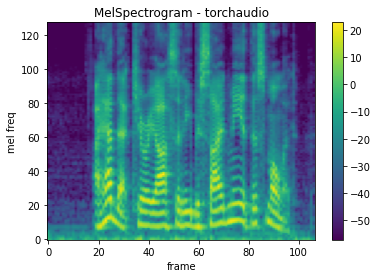

(128, 107)

In [ ]:
import matplotlib.pyplot as plt

from librosa import load, power_to_db
from librosa.feature import melspectrogram

audio_path = "nell_20s.wav"
# audio_path = SAMPLE_SPEECH
# sr, wav_data = wavfile.read(audio_path)
# print(wav_data.shape)

d, sr = load(audio_path, sr=None, mono=None)
d = np.transpose(d)
nbits =16
d *= (2 ** (nbits - 1))

# print(d.shape)
# print(sr)

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

# mm = melspectrogram(
#     y=d,
#     sr=sr,
#     n_fft=n_fft,
#     win_length=win_length,
#     hop_length=hop_length,   
#     center=True,
#     pad_mode="reflect",
#     power=2.0,
#     # norm
#                     )
# print(mm.shape)
# print(mm.shape)


import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchaudio.utils import download_asset


SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_WAVEFORM, sample_rate = torchaudio.load(SAMPLE_SPEECH)

print(SPEECH_WAVEFORM.shape)
print(d.shape)

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

print(melspec.shape)

# # plot_spectrogram(mm[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")
import librosa
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")
librosa.power_to_db(melspec[0]).shape

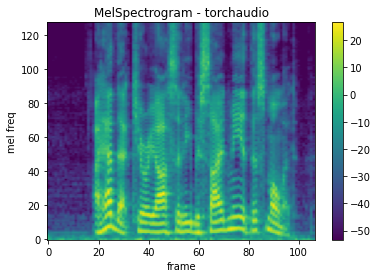

In [ ]:
import matplotlib.pyplot as plt

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")